In [18]:
import torch
import torchvision
import numpy as np
from tqdm import tqdm

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
model = torchvision.models.resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 136)
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')), strict=False)
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1]).to(torch.device('cpu'))
feature_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [37]:
from dataloader import create_dataloaders

dir = "datasets/ears/images-cropped"

test = dir+"/test"
train = dir+"/train"

train_loader, val_loader, test_loader, num_classes = create_dataloaders(train, test, 8)

In [58]:


def featurize_and_labelrize(loader, l=0):
  labels_ar = []
  features_ar = []

  if(l == 0):
    l = len(test_loader)

  with torch.inference_mode():
    for b, labels in tqdm(iter(loader.dataset), total=l):
      # print( labels, b)
      labels_ar.append(labels)
      features_ar.append(feature_extractor(b.unsqueeze(dim=0)).squeeze(dim=0).squeeze(dim=1).squeeze(dim=1))
      if(len(features_ar) > l):
        break
  
  return labels_ar, features_ar

labels_ar, features_ar = featurize_and_labelrize(test_loader, 10)

100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


In [55]:
from sklearn.metrics import pairwise

def calculate_accuracy(features, labels):
    similarity_matrix = pairwise.cosine_distances(features)
    np.fill_diagonal(similarity_matrix, np.inf)
    predicted = labels[np.argmin(similarity_matrix, axis=0)]

    return np.mean(predicted == labels), np.sum(predicted == labels), similarity_matrix

mean score: 0.07317073170731707
 predicted: 3/41


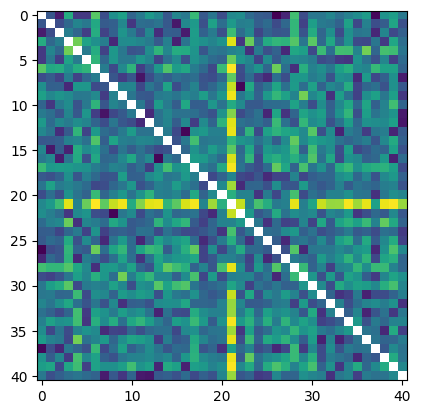

In [56]:
f = np.array(features_ar).reshape(len(features_ar), -1)
l = np.array(labels_ar)
mmean, msum, matrix = calculate_accuracy(features=f, labels=l)

import matplotlib.pyplot as plt

print(f"mean score: {mmean}\n predicted: {msum}/{len(features_ar)}")
plt.imshow(matrix)

100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


IndexError: index 4 is out of bounds for axis 0 with size 4

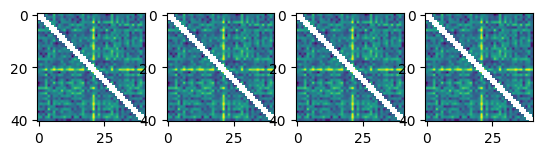

In [62]:
l = 5

fig, axs = plt.subplots(1,4)


for i in range(5):
  labels_ar, features_ar = featurize_and_labelrize(test_loader, 40)
  f = np.array(features_ar).reshape(len(features_ar), -1)
  l = np.array(labels_ar)
  mmean, msum, matrix = calculate_accuracy(features=f, labels=l)
  axs[i].imshow(matrix)